In [272]:

import os
import shutil
import time
from collections import defaultdict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from SALib.analyze import sobol


from ema_workbench import (
    Model, Policy, Scenario, MultiprocessingEvaluator,
    ema_logging
)
from ema_workbench.analysis import (
    feature_scoring, parcoords, pairs_plotting, prim
)
from ema_workbench.em_framework.evaluators import (
    BaseEvaluator, perform_experiments
)
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, EpsilonProgress, EpsNSGAII,
    HyperVolume, epsilon_nondominated, to_problem
)
from ema_workbench.em_framework.outcomes import ScalarOutcome
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties


from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import dimensional_stacking
from pandas.api.types import is_numeric_dtype, is_categorical_dtype




## Running and showing the model

In [454]:
if __name__ == "__main__":

    # --- Load your model ---
    model, planning_steps = get_model_for_problem_formulation(3)



    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)


    convergence_metrics = [

    EpsilonProgress(),
]

    espilon = [0.01] * len(model.outcomes)


    nfe = 2000  # proof of principle only, way to low for actual use

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=espilon,
            convergence=convergence_metrics, reference=ref_scenario,

        )

[MainProcess/INFO] pool started with 8 workers
 95%|████████████████████████████████████  | 1900/2000 [04:14<00:13,  7.24it/s]INFO | EpsNSGAII running; NFE Complete: 2000, Elapsed Time: 0:04:31.697557
INFO | EpsNSGAII finished; Total NFE: 2000, Elapsed Time: 0:04:31.698745
100%|██████████████████████████████████████| 2000/2000 [04:31<00:00,  7.36it/s]
[MainProcess/INFO] optimization completed, found 19 solutions
[MainProcess/INFO] terminating pool


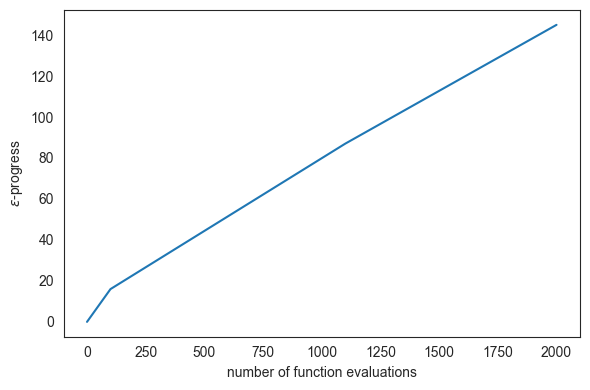

In [455]:
fig, ax1 = plt.subplots(figsize=(6, 4))  # no ncols=2

ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel(r'$\epsilon$-progress')
ax1.set_xlabel('number of function evaluations')
plt.savefig("convergence enkel MORDM.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



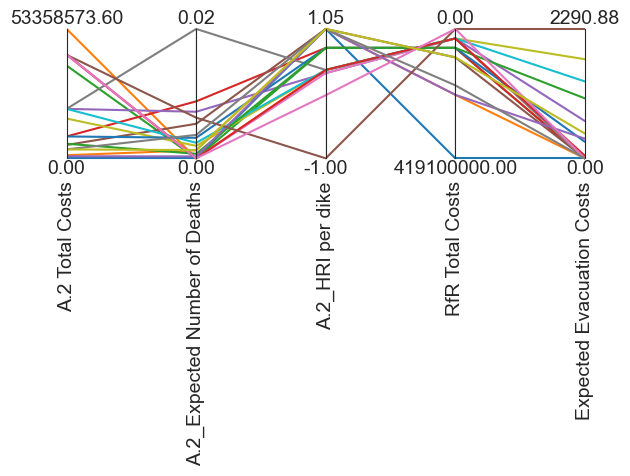

<Figure size 1400x1000 with 0 Axes>

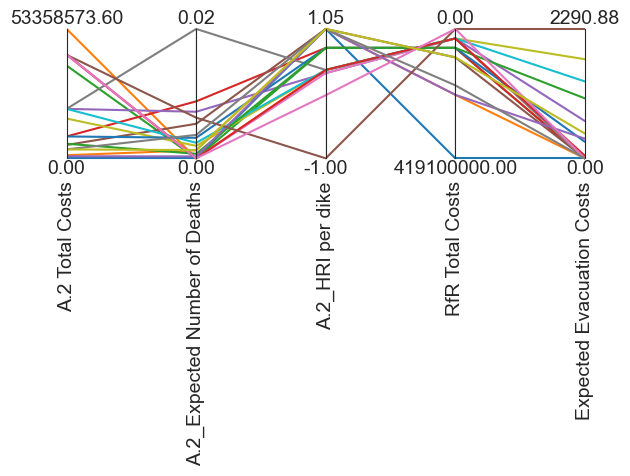

In [456]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))  # width=12 inches, height=8 inches

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel coordinates all.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [457]:
logical = (
    (results["A.2 Total Costs"] < 7e7) &

    (results["A.2_HRI per dike"] > 1))



np.sum(logical)

np.int64(6)

In [518]:

results_1 = results[logical]
results_1["policy"] = results_1.index  # Automatically uses 16, 17, 18 in your case


data = results_1.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")


legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

TypeError: tuple indices must be integers or slices, not Series

## optimized policies

In [460]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,1,0,0,0,0,1,1,1,0,...,0,4,4,4,6,1,9,9,7,6
5,0,0,0,0,0,0,1,1,1,0,...,0,2,6,5,5,0,10,7,0,1
11,0,0,0,0,0,0,1,1,1,1,...,0,1,1,2,7,2,5,6,4,6
14,0,0,0,0,0,0,1,1,1,0,...,0,2,4,3,4,1,1,7,3,1
17,0,0,0,0,0,0,1,1,0,0,...,0,3,4,3,10,1,1,6,3,1
18,0,0,0,0,0,0,1,1,1,0,...,0,2,5,2,4,1,6,7,0,1


In [461]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [462]:
#Create policy dataframe
lever_names = [l.name for l in model.levers]
policies_df = results[lever_names]
policies_df.to_csv("candidate_policies.csv", index=False)

## Testing out the policies

In [463]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████████| 600/600 [01:30<00:00,  6.61it/s]
[MainProcess/INFO] terminating pool


In [464]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [465]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,1.257810e+16,0.000123,1.847521,419100000.0,4.317967e+07
11,1.429062e+16,0.009889,1.714926,213300000.0,0.000000e+00
14,1.262990e+16,0.001093,1.714926,213300000.0,2.292087e+07
17,1.908301e+16,0.012957,1.531222,182600000.0,0.000000e+00
18,1.428239e+16,0.001238,1.636634,92100000.0,2.528967e+07
5,1.639277e+16,0.011343,1.636634,92100000.0,0.000000e+00


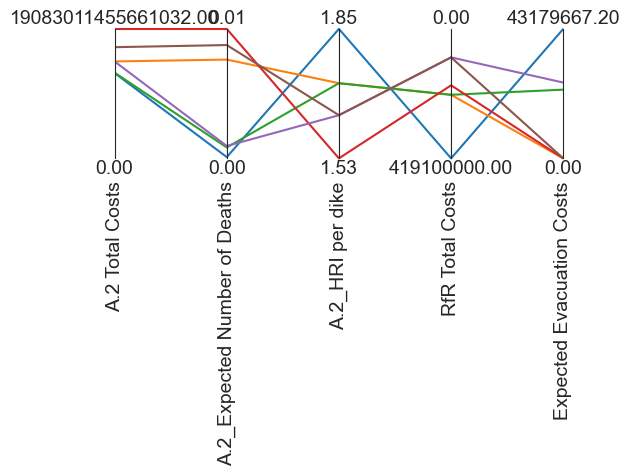

<Figure size 1400x1000 with 0 Axes>

In [466]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths', 'RfR Total Costs',"Expected Evacuation Costs"]] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
plt.figure(figsize=(14, 10))
plt.savefig("scores_single_MORDM.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches
plt.show()

In [467]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [468]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

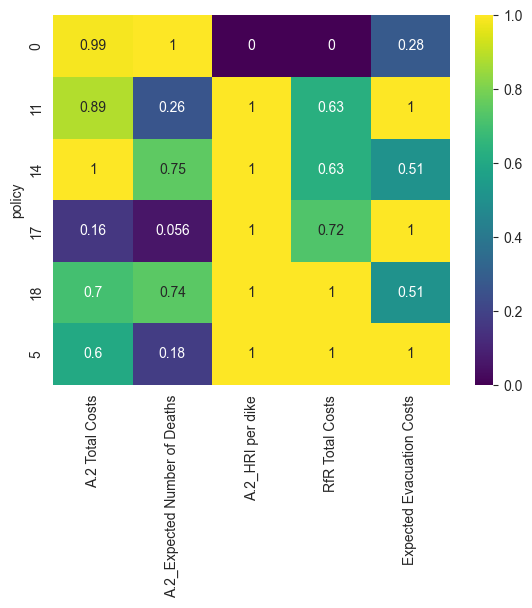

In [469]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("regret_single_MORDM.png", dpi=300, bbox_inches='tight')
plt.show()

In [470]:

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

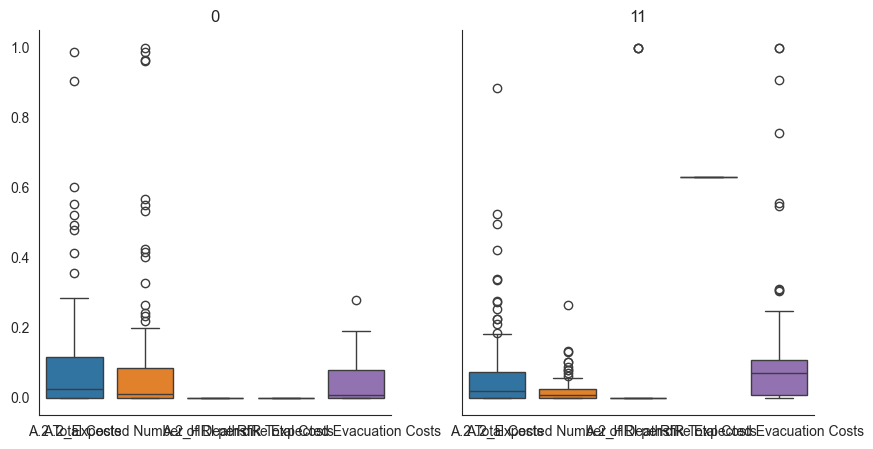

In [471]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.


# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

## Selecteren scenarios maar gaan we doen met PRIM

In [474]:
policies_df = pd.read_csv("candidate_policies.csv")

# zet elke rij om in een Policy-object
candidate_policies = [
    Policy(f"cand_{i}", **row.to_dict())
    for i, row in policies_df.iterrows()

    ]

In [475]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(3)
    scenarios=10
    policies=4
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=candidate_policies )

        experiments, outcomes = results

[MainProcess/INFO] pool started with 7 workers
100%|████████████████████████████████████████| 190/190 [00:33<00:00,  5.65it/s]
[MainProcess/INFO] terminating pool


In [476]:
hri_sys = outcomes["A.2_HRI per dike"]
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
ead_total = outcomes["A.2 Total Costs"] # (N,)
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_ead        # booleaanse vector (N,)
print(f"worst-cases: {y.sum()} van {n_scenarios*policies} runs  ({y.mean()*100:.1f} %)")

        #Determine model uncertainties
cols_unc = [u.name for u in model.uncertainties]
X = experiments[cols_unc]

#Start PRIM
prim_alg = prim.Prim(
            X, y,
            threshold=0.80,
        )

print("Aantal opgeslagen boxen:", len(prim_alg.boxes))

worst-cases: 72 van 400 runs  (37.9 %)
Aantal opgeslagen boxen: 1


[MainProcess/INFO] 190 points remaining, containing 72 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2, coverage: 0.5277777777777778, density: 1.0 restricted_dimensions: 4
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{10.0, 1.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{10.0, 1.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


coverage     0.527778
density      1.000000
id           6.000000
k           38.000000
mass         0.200000
mean         1.000000
n           38.000000
res_dim      4.000000
Name: 6, dtype: float64

                 box 6                                    
                   min          max qp value      qp value
A.2_pfail     0.042627     0.196025      NaN  1.134044e-10
A.1_Bmax     64.071612    326.79255      1.0           NaN
A.2_Brate  {10.0, 1.5}  {10.0, 1.5}      1.0           NaN
A.4_Brate  {1.0, 10.0}  {1.0, 10.0}      1.0           NaN



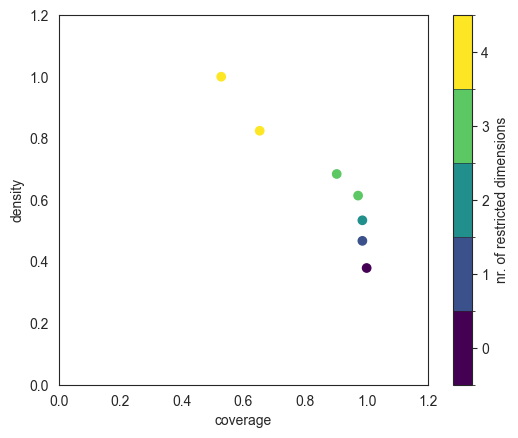

7 stappen in deze box


In [477]:
# A) De “beste” box volgens je threshold
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()
plt.show()# geeft een PrimBox terug
traj = box.peeling_trajectory
print(len(traj), "stappen in deze box")

[<Figure size 640x480 with 1 Axes>]

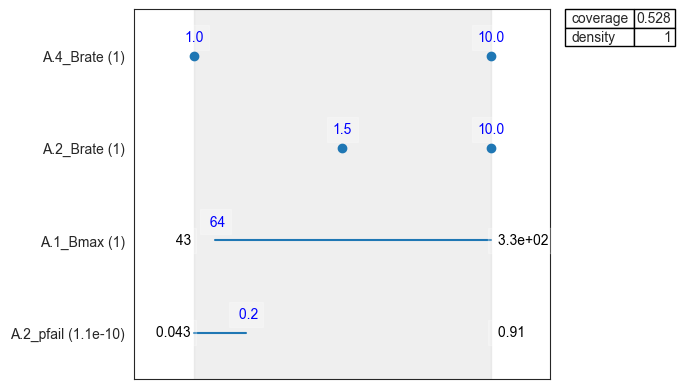

In [478]:
# en inspecteer 'm meteen
box.inspect( style="graph" )

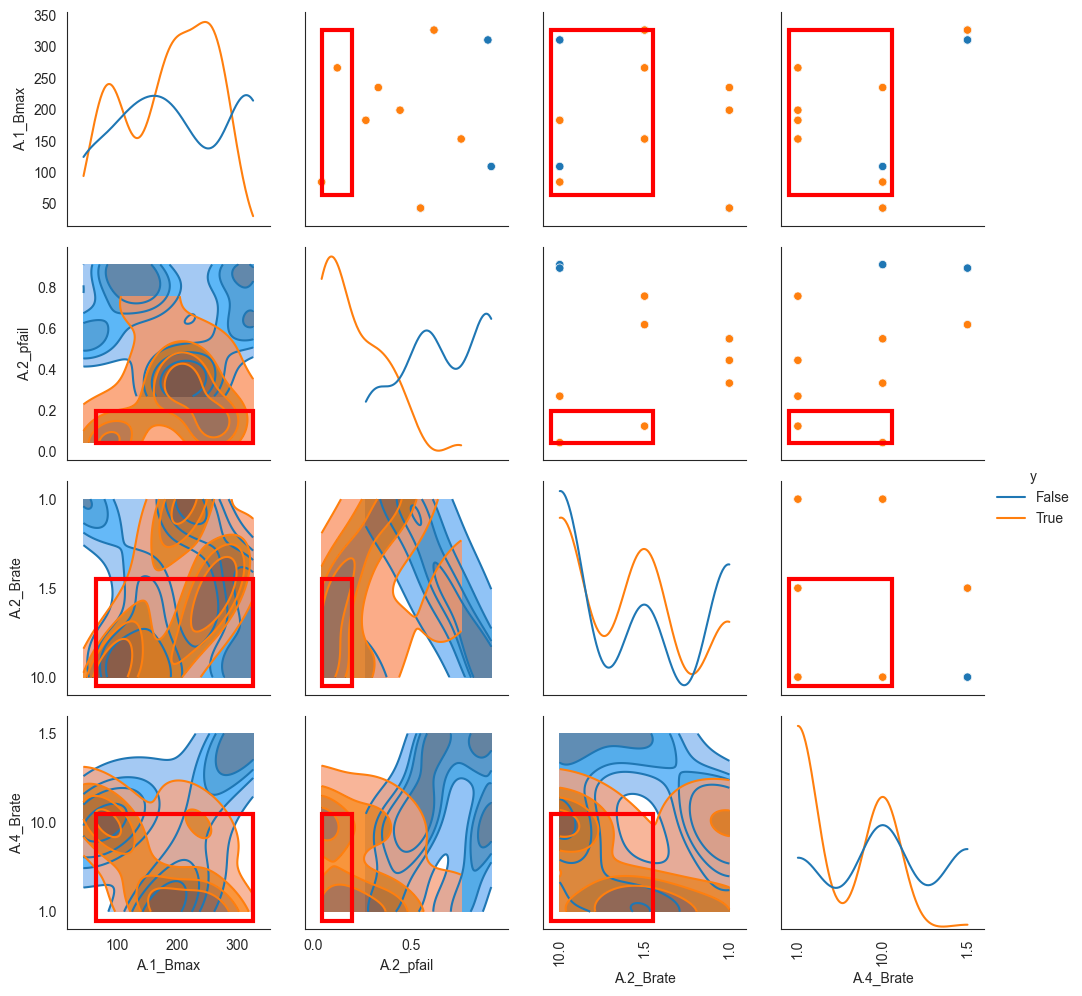

In [479]:
fig = box.show_pairs_scatter()
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category


origineel aantal kolommen: 53
zonder levers           : 22


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


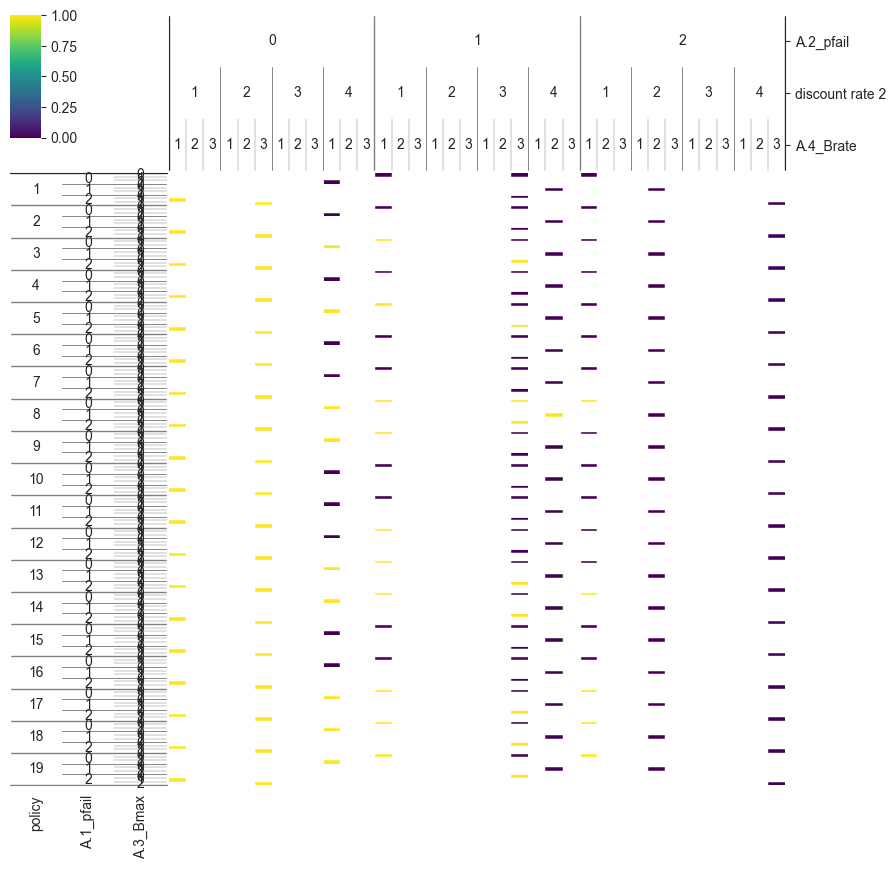

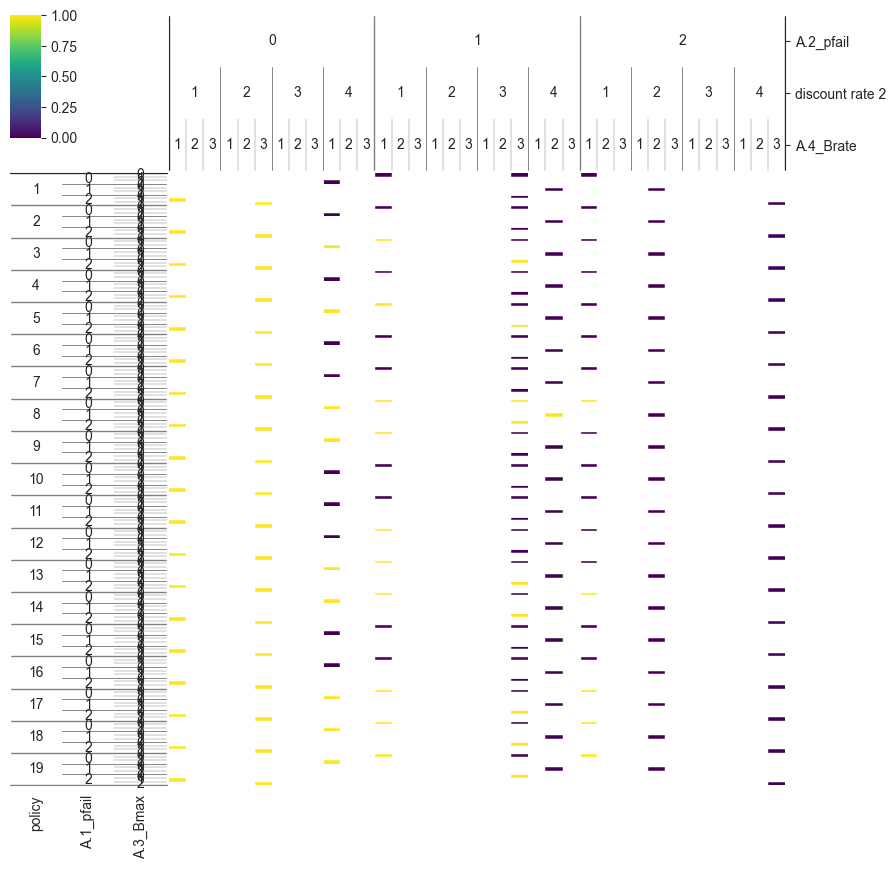

In [480]:
lever_names = [lev.name for lev in model.levers]
experiments_unc = experiments.drop(columns=lever_names)


# even checken:
print("origineel aantal kolommen:", experiments.shape[1])
print("zonder levers           :", experiments_unc.shape[1])

dimensional_stacking.create_pivot_plot(experiments_unc, y)


In [481]:

# 1) Haal de grenzen op uit de box (list met één entry per box in je peeling_trajectory)
raw_limits = box.box_lims[0]

# 1) Transponeren, zodat elke var een rij wordt, en de kolommen 0 en 1 zijn
df_lim = raw_limits.T

# 2) Hernoemen van de kolommen 0→min en 1→max
df_lim = df_lim.rename(columns={0: "min", 1: "max"})

# 3) (optioneel) zet de index-naam netjes
df_lim.index.name = "var"

In [482]:
df_lim
mask = pd.Series(True, index=experiments.index)

for var, row in df_lim.iterrows():
    lo, hi = row["min"], row["max"]
    ser = experiments[var]

    if is_numeric_dtype(ser):
        # voor numerieke parameters
        mask &= ser.between(lo, hi)
    else:
        # voor categorische parameters
        # lo kan een set/list zijn, of een enkele waarde
        if isinstance(lo, (set, list)):
            mask &= ser.isin(lo)
        else:
            mask &= (ser == lo)

exp_in_box = experiments[mask]
out_in_box = {
    name: array[mask.values]  # .values is een numpy‐boolean array
    for name, array in outcomes.items()
}

In [483]:
expanded = {}
for name, arr in out_in_box.items():
    if arr.ndim == 1:
        # gewoon een vector
        expanded[name] = arr
    else:
        # maak per tijdstap een kolom
        T = arr.shape[1]
        for t in range(T):
            expanded[f"{name}_{t}"] = arr[:, t]

out_df = pd.DataFrame(expanded)

In [484]:
exp_in_box['worst_case']=y[exp_in_box.index]
true_worst= exp_in_box[exp_in_box['worst_case']]
#
# true_worst = true_worst.assign(
#     total_cost = out_in_box['A.2 Total Costs']
# )

In [485]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2 Total Costs'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_costs = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(total_costs=worst_costs)

In [486]:
true_worst['total_costs'] = pd.Series(
    out_in_box['A.2 Total Costs'],
    index=exp_in_box.index
).loc[true_worst.index]

In [487]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs
6,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,1,9,9,7,6,676,cand_0,dikesnet,True,1.813269e+08
7,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,1,9,9,7,6,677,cand_0,dikesnet,True,5.929802e+08
16,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,0,4,5,4,10,676,cand_1,dikesnet,True,8.697829e+07
17,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,0,4,5,4,10,677,cand_1,dikesnet,True,1.699594e+08
24,78,199.213339,10.0,0.199036,247.582581,1.0,0.444263,108.765743,1.0,0.464374,...,0,10,5,3,6,674,cand_2,dikesnet,True,6.576581e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,9,183.118868,10.0,0.080857,48.418561,10.0,0.269136,266.494769,1.0,0.107374,...,1,4,5,4,1,679,cand_16,dikesnet,True,7.839400e+07
176,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,1,1,6,3,1,676,cand_17,dikesnet,True,3.604910e+08
177,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,1,1,6,3,1,677,cand_17,dikesnet,True,9.348287e+08
186,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,1,6,7,0,1,676,cand_18,dikesnet,True,2.798350e+08


In [488]:
# --- 1) Maak één Series van alle total costs, met de originele index ---
all_costs = pd.Series(
    out_in_box['A.2_HRI per dike'],       # numpy array voor _alle_ runs in out_in_box
    index = exp_in_box.index              # die hoort dezelfde lengte en index labels te hebben
)

# --- 2) Filter die Series naar alleen de worst‐case subset (true_worst.index) ---
worst_HRI = all_costs.loc[true_worst.index]

# --- 3) Wijs die gefilterde Series toe als nieuwe kolom ---
true_worst = true_worst.assign(HRI=worst_HRI)

In [489]:
true_worst

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,worst_case,total_costs,HRI
6,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,9,9,7,6,676,cand_0,dikesnet,True,1.813269e+08,0.05
7,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,9,9,7,6,677,cand_0,dikesnet,True,5.929802e+08,0.05
16,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,4,5,4,10,676,cand_1,dikesnet,True,8.697829e+07,-0.60
17,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,4,5,4,10,677,cand_1,dikesnet,True,1.699594e+08,-0.60
24,78,199.213339,10.0,0.199036,247.582581,1.0,0.444263,108.765743,1.0,0.464374,...,10,5,3,6,674,cand_2,dikesnet,True,6.576581e+07,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,9,183.118868,10.0,0.080857,48.418561,10.0,0.269136,266.494769,1.0,0.107374,...,4,5,4,1,679,cand_16,dikesnet,True,7.839400e+07,0.00
176,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,1,6,3,1,676,cand_17,dikesnet,True,3.604910e+08,0.05
177,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,1,6,3,1,677,cand_17,dikesnet,True,9.348287e+08,0.05
186,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,6,7,0,1,676,cand_18,dikesnet,True,2.798350e+08,0.05


In [490]:
# 1) min-max schaal HRI en costs
hri = true_worst['HRI']
cost = true_worst['total_costs']

hri_scaled = (hri - hri.min()) / (hri.max() - hri.min())
cost_scaled = (cost - cost.min()) / (cost.max() - cost.min())

# 2) keer de costs om
inv_cost = 1 - cost_scaled

# 3) bereken de samengestelde score
score = hri_scaled * inv_cost

# 4) voeg toe aan true_worst
true_worst = true_worst.assign(
    hri_scaled = hri_scaled,
    cost_scaled = cost_scaled,
    inv_cost    = inv_cost,
    score       = score
)

true_worst.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,scenario,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
6,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,676,cand_0,dikesnet,True,1.813269e+08,0.05,1.000000,0.138837,0.861163,0.861163
7,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,677,cand_0,dikesnet,True,5.929802e+08,0.05,1.000000,0.507467,0.492533,0.492533
16,96,266.627201,1.5,0.818802,331.673436,1.5,0.122915,227.857007,1.5,0.779849,...,676,cand_1,dikesnet,True,8.697829e+07,-0.60,0.380952,0.054349,0.945651,0.360248
17,28,84.791079,1.0,0.900048,210.881010,10.0,0.042627,348.805958,10.0,0.800752,...,677,cand_1,dikesnet,True,1.699594e+08,-0.60,0.380952,0.128658,0.871342,0.331940
24,78,199.213339,10.0,0.199036,247.582581,1.0,0.444263,108.765743,1.0,0.464374,...,674,cand_2,dikesnet,True,6.576581e+07,-0.25,0.714286,0.035354,0.964646,0.689033


In [491]:
# # 1) voeg y als kolom toe
# exp_in_box = exp_in_box.copy()
# exp_in_box['worst_case'] = y[exp_in_box.index]
#
# # 2) houd alleen echte worst-cases over
# true_worst = exp_in_box[exp_in_box['worst_case']]

# 3) kies uit true_worst je max/min/median voor EAD & HRI
best  = true_worst.nlargest(1, 'score')   #best case is hoogste
worst = true_worst.nsmallest(1,  'score')      #worst case is laagste
mid   = true_worst.iloc[[len(true_worst)//2]]

In [492]:
# 1) knijp de rij samen naar een Series
best_s   = best.iloc[0]  # of .iloc[0]
mid_s = mid.iloc[0]
worst_s  = worst.iloc[0]



df_scenarios = pd.DataFrame([
    best_s.to_dict(),
    mid_s.to_dict(),
    worst_s.to_dict()
], index=["best_case", "median_case", "worst_case"])

df_scenarios = (
    df_scenarios
    .rename(columns={"scenario.1": "scenario"})  # als hij zo heet
    .set_index("scenario")                        # zet de kolom als index
)

In [493]:
df_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 2,policy,model,worst_case,total_costs,HRI,hri_scaled,cost_scaled,inv_cost,score
scenario,,,,,,,,,,,,,,,,,,,,,
679,9,183.118868,10.0,0.080857,48.418561,10.0,0.269136,266.494769,1.0,0.107374,...,1,cand_16,dikesnet,True,7.839400e+07,0.0,0.952381,0.046662,0.953338,0.907941
675,13,235.283032,1.5,0.759325,161.468442,1.0,0.332851,93.673105,1.5,0.047761,...,6,cand_9,dikesnet,True,7.813344e+07,-0.6,0.380952,0.046429,0.953571,0.363265
671,109,43.352146,1.0,0.226050,270.245773,1.0,0.549199,61.125057,10.0,0.910512,...,1,cand_15,dikesnet,True,5.133335e+07,-1.0,0.000000,0.022429,0.977571,0.000000


In [494]:
df_scenarios.to_csv("reference_scenarios.csv", index_label="scenario")


In [495]:
candidate_scenarios = [
    Scenario(f"scenario_{idx}", **row.to_dict())
    for idx, row in df_scenarios.iterrows()
]

In [496]:
for scenario in candidate_scenarios:
    print(scenario)

Scenario({'A.0_ID flood wave shape': 9, 'A.1_Bmax': 183.11886782643575, 'A.1_Brate': 10.0, 'A.1_pfail': 0.08085661818585999, 'A.2_Bmax': 48.4185609410076, 'A.2_Brate': 10.0, 'A.2_pfail': 0.2691357535952136, 'A.3_Bmax': 266.4947686622098, 'A.3_Brate': 1.0, 'A.3_pfail': 0.10737397206112888, 'A.4_Bmax': 169.13087144687816, 'A.4_Brate': 1.0, 'A.4_pfail': 0.40469234970506157, 'A.5_Bmax': 249.03124806440502, 'A.5_Brate': 10.0, 'A.5_pfail': 0.1630544986409757, 'discount rate 0': 2.5, 'discount rate 1': 3.5, 'discount rate 2': 4.5, '0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 3, 'A.1_DikeIncrease 0': 5, 'A.1_DikeIncrease 1': 6, 'A.1_DikeIncrease 2': 5, 'A.2_DikeIncrease 0': 2, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 5, 'A.3_DikeIncrease 1': 6, 'A.3_DikeIncrease 2': 5, 'A.4_DikeInc

## scenario's uit PRIM

In [497]:
# df_scenarios= pd.read_csv('reference_scenarios.csv')
#
# df_scenarios = (
#     df_scenarios
#     .rename(columns={"scenario.1": "scenario"})
#     .set_index("scenario")            )

In [498]:
# df_scenarios=df_scenarios[cols_unc]
# df_scenarios

In [499]:
    # candidate_scenarios = [
    #     Scenario(f"scenario_{idx}", **row.to_dict())
    #     for idx, row in df_scenarios.iterrows()
    # ]

## vanaf hier wordt het multi MORDM

In [500]:

ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

In [501]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.optimization import to_problem
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)


nfe = 100
epsilons = [0.01] * len(model.outcomes)

results = []
convergence_records = []

with MultiprocessingEvaluator(model) as evaluator:
    for i, scenario in enumerate(candidate_scenarios[:3]):
        for seed in range(5):
            print(f"🔄 Running: Scenario {i} ({scenario.name}) | Seed {seed}")

            eps_prog = EpsilonProgress()
            result, convergence = evaluator.optimize(
                nfe=nfe,
                searchover="levers",
                epsilons=epsilons,
                convergence=[eps_prog],
                reference=scenario,
            )

            # Store optimization results
            results.append(pd.DataFrame(result))

            # The convergence object is a DataFrame already
            convergence_df = pd.DataFrame(convergence)
            convergence_df["scenario"] = scenario.name
            convergence_df["seed"] = seed
            convergence_records.append(convergence_df)

# Merge final dataframes
combined_results = pd.concat(results, ignore_index=True)
convergence_df = pd.concat(convergence_records, ignore_index=True)

[MainProcess/INFO] pool started with 8 workers


🔄 Running: Scenario 0 (scenario_679) | Seed 0


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:18.461901
100%|████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]
[MainProcess/INFO] optimization completed, found 18 solutions


🔄 Running: Scenario 0 (scenario_679) | Seed 1


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:14.237021
100%|████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]
[MainProcess/INFO] optimization completed, found 18 solutions


🔄 Running: Scenario 0 (scenario_679) | Seed 2


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:11.728587
100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.52it/s]
[MainProcess/INFO] optimization completed, found 30 solutions


🔄 Running: Scenario 0 (scenario_679) | Seed 3


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:12.017673
100%|████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]
[MainProcess/INFO] optimization completed, found 22 solutions


🔄 Running: Scenario 0 (scenario_679) | Seed 4


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:11.324241
100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.83it/s]
[MainProcess/INFO] optimization completed, found 25 solutions


🔄 Running: Scenario 1 (scenario_675) | Seed 0


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:11.859738
100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.43it/s]
[MainProcess/INFO] optimization completed, found 15 solutions


🔄 Running: Scenario 1 (scenario_675) | Seed 1


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:12.009173
100%|████████████████████████████████████████| 100/100 [00:12<00:00,  8.33it/s]
[MainProcess/INFO] optimization completed, found 24 solutions


🔄 Running: Scenario 1 (scenario_675) | Seed 2


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:11.343824
100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.81it/s]
[MainProcess/INFO] optimization completed, found 18 solutions


🔄 Running: Scenario 1 (scenario_675) | Seed 3


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:11.150371
100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.97it/s]
[MainProcess/INFO] optimization completed, found 35 solutions


🔄 Running: Scenario 1 (scenario_675) | Seed 4


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:13.237229
100%|████████████████████████████████████████| 100/100 [00:13<00:00,  7.55it/s]
[MainProcess/INFO] optimization completed, found 9 solutions


🔄 Running: Scenario 2 (scenario_671) | Seed 0


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:15.285455
100%|████████████████████████████████████████| 100/100 [00:15<00:00,  6.54it/s]
[MainProcess/INFO] optimization completed, found 17 solutions


🔄 Running: Scenario 2 (scenario_671) | Seed 1


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:12.595564
100%|████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]
[MainProcess/INFO] optimization completed, found 24 solutions


🔄 Running: Scenario 2 (scenario_671) | Seed 2


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:13.117765
100%|████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]
[MainProcess/INFO] optimization completed, found 12 solutions


🔄 Running: Scenario 2 (scenario_671) | Seed 3


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:12.840262
100%|████████████████████████████████████████| 100/100 [00:12<00:00,  7.79it/s]
[MainProcess/INFO] optimization completed, found 17 solutions


🔄 Running: Scenario 2 (scenario_671) | Seed 4


  0%|                                                  | 0/100 [00:00<?, ?it/s]INFO | EpsNSGAII starting
INFO | EpsNSGAII finished; Total NFE: 100, Elapsed Time: 0:00:11.876743
100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.42it/s]
[MainProcess/INFO] optimization completed, found 14 solutions
[MainProcess/INFO] terminating pool


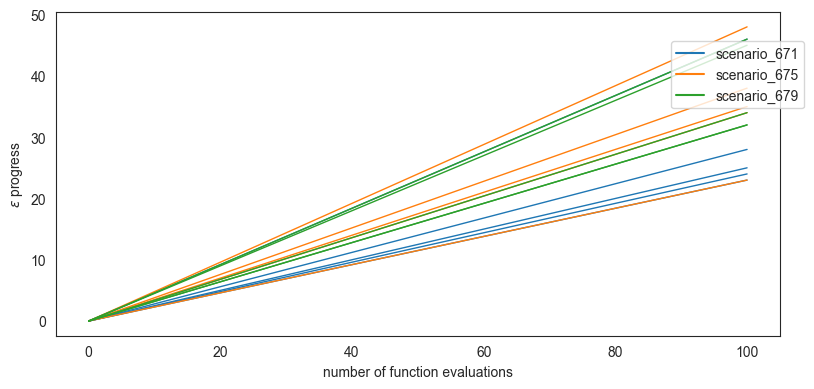

In [506]:
# === PLOT ε-PROGRESS BY SCENARIO ===
fig, ax = plt.subplots(figsize=(8, 4))
colors = sns.color_palette()
legend_items = []

for (scenario_name, scores), color in zip(convergence_df.groupby("scenario"), colors):
    # Create custom legend item
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))

    # Plot each seed
    for seed, score in scores.groupby("seed"):
        ax.plot(score.nfe, score.epsilon_progress, c=color, lw=1)

ax.set_ylabel(r'$\epsilon$ progress')
ax.set_xlabel('number of function evaluations')

# Add legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1.02, 0.9))

plt.tight_layout()
plt.savefig("convergence_multi_mordm.png", dpi=300, bbox_inches='tight')
plt.show()

In [507]:
combined_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
0,0,1,0,0,1,0,0,0,1,0,...,7,9,5,1,7,1.291979e+08,0.000042,0.59,5.755000e+08,39309.239873
1,1,0,1,0,1,0,1,0,0,1,...,4,8,5,4,1,1.087456e+08,0.000253,1.02,9.162000e+08,18.698970
2,1,0,1,1,1,0,1,1,1,1,...,7,6,1,2,8,9.585104e+07,0.000675,1.03,1.586400e+09,0.000000
3,0,0,1,0,0,0,0,1,1,0,...,1,0,7,1,5,1.952595e+08,0.000000,1.04,9.143000e+08,0.000000
4,1,1,1,0,0,1,1,0,1,0,...,2,10,6,4,6,1.614230e+08,0.029978,1.03,7.891000e+08,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,0,1,1,0,0,1,0,1,0,...,4,4,3,10,8,1.189095e+08,0.000944,0.63,9.972000e+08,282.492974
294,0,1,0,0,0,0,1,1,0,0,...,3,0,2,0,10,2.865293e+08,0.000000,0.69,5.233000e+08,0.000000
295,0,1,0,1,1,1,1,0,1,1,...,6,6,8,7,1,1.023364e+08,0.000000,1.03,1.176700e+09,0.000000
296,0,1,0,1,0,0,1,1,1,1,...,7,9,5,0,10,1.703800e+08,0.000000,1.05,8.930000e+08,0.000000


In [508]:
print(combined_results)

     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0          0        1        0        0        1        0        0        0   
1          1        0        1        0        1        0        1        0   
2          1        0        1        1        1        0        1        1   
3          0        0        1        0        0        0        0        1   
4          1        1        1        0        0        1        1        0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
293        0        0        1        1        0        0        1        0   
294        0        1        0        0        0        0        1        1   
295        0        1        0        1        1        1        1        0   
296        0        1        0        1        0        0        1        1   
297        1        0        1        0        1        0        1        1   

     2_RfR 2  3_RfR 0  ...  A.4_DikeIncrease 1  A.4

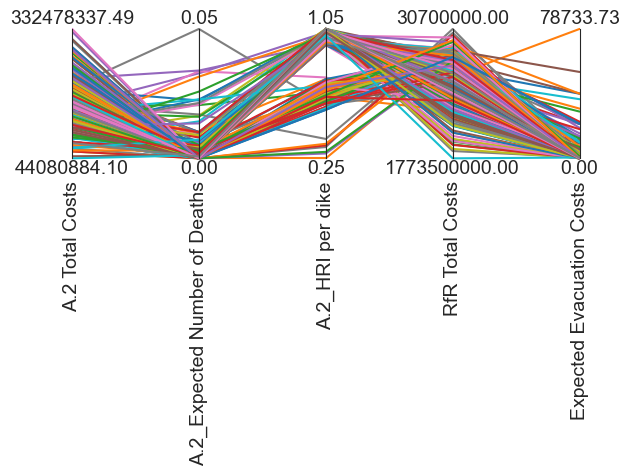

<Figure size 1400x1000 with 0 Axes>

In [509]:
data = combined_results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")
    # Set larger figure size (wider and taller)
plt.figure(figsize=(14, 10))
plt.savefig("multi mordm all.png", dpi=300, bbox_inches='tight') # width=12 inches, height=8 inches


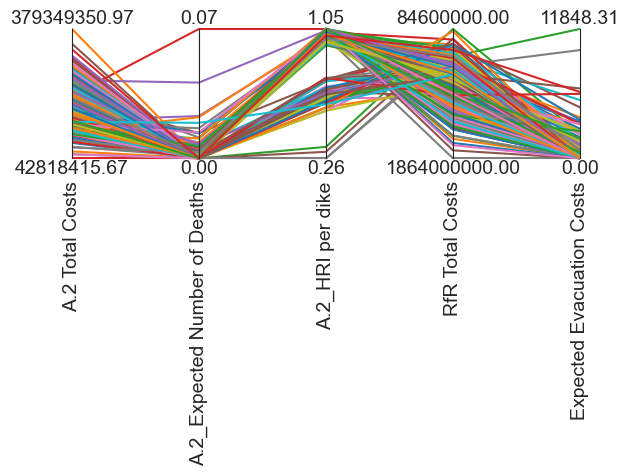

In [432]:

# Generate parallel axes with your limits
paraxes = parcoords.ParallelAxes(limits)

# Plot the data
paraxes.plot(data)

# Invert specific axis
paraxes.invert_axis("RfR Total Costs")

# Save the plot
plt.savefig("mordm_parallel_coordinates.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [511]:



logical = (
    (combined_results["A.2 Total Costs"] < 7e7) &

    (combined_results["A.2_HRI per dike"] > 1))



np.sum(logical)
combined_results[logical]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
77,0,0,1,1,1,1,1,1,0,1,...,7,1,8,8,7,6.604510e+07,0.000000,1.05,1.675200e+09,677.650777
98,0,0,0,0,0,0,0,1,0,1,...,0,10,10,1,2,5.941010e+07,0.000000,1.05,5.292000e+08,8775.446109
113,1,0,0,0,1,0,0,0,1,0,...,2,8,1,2,6,5.941010e+07,0.000000,1.05,7.104000e+08,20892.338869
149,1,0,1,1,0,1,1,0,1,1,...,0,3,10,4,2,6.672889e+07,0.005413,1.05,1.299600e+09,434.493316
265,0,0,1,0,1,0,0,0,0,1,...,2,10,1,8,4,4.868948e+07,0.001099,1.05,8.009000e+08,0.000000
279,0,0,0,0,1,1,1,1,1,1,...,9,6,10,6,4,4.408088e+07,0.001095,1.04,1.147400e+09,336.676942
289,0,1,1,1,1,1,1,1,0,0,...,3,1,4,3,2,6.777991e+07,0.006606,1.01,1.773500e+09,509.831982


/var/folders/sp/3r57ckwj0f59wpwykds8r5040000gn/T/ipykernel_17495/2740734344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


<Figure size 1400x1000 with 0 Axes>

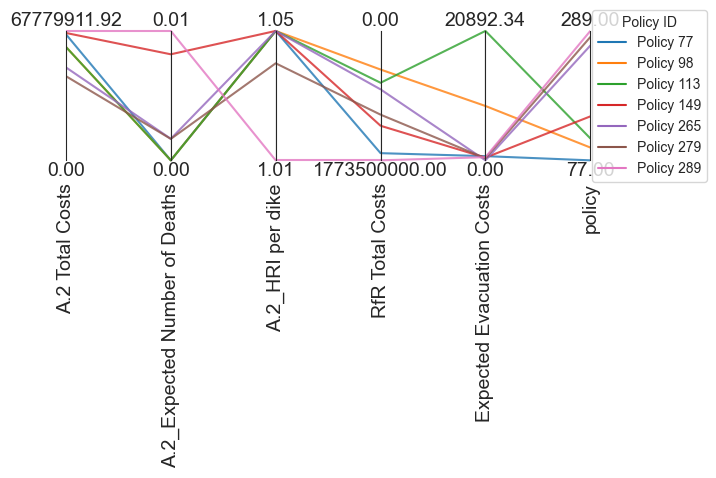

In [513]:

results_2 = combined_results[logical]
results_2["policy"] = results_2.index  # Automatically uses 16, 17, 18 in your case


data = results_2.loc[:, [o.name for o in model.outcomes] + ['policy']]


limits = parcoords.get_limits(data)
limits.loc[0, ['A.2 Total Costs', 'A.2_Expected Number of Deaths',
               'RfR Total Costs', 'Expected Evacuation Costs']] = 0


policy_ids = data["policy"].unique()
colors = sns.color_palette("tab10", len(policy_ids))
color_map = dict(zip(policy_ids, colors))


plt.figure(figsize=(14, 10))
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy row with its assigned color
for _, row in data.iterrows():
    policy_id = row["policy"]
    color = color_map.get(policy_id, "gray")
    paraxes.plot(row.to_frame().T, color=color, alpha=0.8)

# Invert axis if needed
paraxes.invert_axis("RfR Total Costs")


legend_handles = [
    Line2D([0], [0], color=color_map[pid], label=f"Policy {pid}")
    for pid in policy_ids
]
plt.legend(handles=legend_handles, title="Policy ID", loc="center left",bbox_to_anchor=(1.02, 0.5),borderaxespad=0)


plt.savefig("parallel_coords_multi_MORDM_selected_policies.png", dpi=300, bbox_inches='tight')
plt.show()

In [514]:
policies = combined_results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
77,0,0,1,1,1,1,1,1,0,1,...,0,0,8,3,8,7,1,8,8,7
98,0,0,0,0,0,0,0,1,0,1,...,0,10,6,10,0,0,10,10,1,2
113,1,0,0,0,1,0,0,0,1,0,...,0,3,9,0,0,2,8,1,2,6
149,1,0,1,1,0,1,1,0,1,1,...,0,9,10,5,2,0,3,10,4,2
265,0,0,1,0,1,0,0,0,0,1,...,0,1,1,10,1,2,10,1,8,4
279,0,0,0,0,1,1,1,1,1,1,...,1,7,10,0,7,9,6,10,6,4
289,0,1,1,1,1,1,1,1,0,0,...,4,9,4,6,6,3,1,4,3,2


## Hier onder worden de policies gemaakt die getest moeten worden

In [515]:

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [516]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
100%|████████████████████████████████████████| 700/700 [01:50<00:00,  6.32it/s]
[MainProcess/INFO] terminating pool


In [448]:
results

(     A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
 0                        126  258.252022      10.0   0.010069  275.561114   
 1                         89   89.673479       1.0   0.235037  171.261146   
 2                        110   86.108612       1.0   0.846395  340.760638   
 3                         27  231.375715      10.0   0.570687  278.324526   
 4                         83  272.860739      10.0   0.405827  283.632715   
 ..                       ...         ...       ...        ...         ...   
 395                       50  120.749297       1.5   0.077725  307.772626   
 396                       68   46.654773       1.0   0.262337   87.291900   
 397                      126  161.539290       1.0   0.689958  140.695939   
 398                       73  183.513855       1.5   0.666600  201.669815   
 399                      114  211.723734      10.0   0.863615  248.245097   
 
     A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ..

In [449]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std


In [450]:
from ema_workbench import ScalarOutcome

experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.2 Total Costs,A.2_Expected Number of Deaths,A.2_HRI per dike,RfR Total Costs,Expected Evacuation Costs
103,6.533778e+15,0.000043,2.342713,6.445000e+08,3.794937e+07
107,4.390071e+15,0.000032,3.004253,1.274800e+09,6.806664e+06
236,3.276837e+15,0.000846,3.354511,9.745000e+08,0.000000e+00
51,1.299795e+15,0.000002,4.588315,1.595900e+09,3.669641e+06


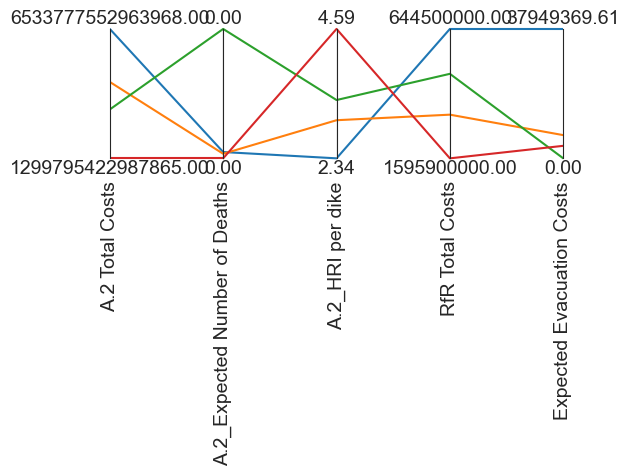

In [451]:
data = scores
limits = parcoords.get_limits(data)


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("RfR Total Costs")

plt.show()

In [452]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

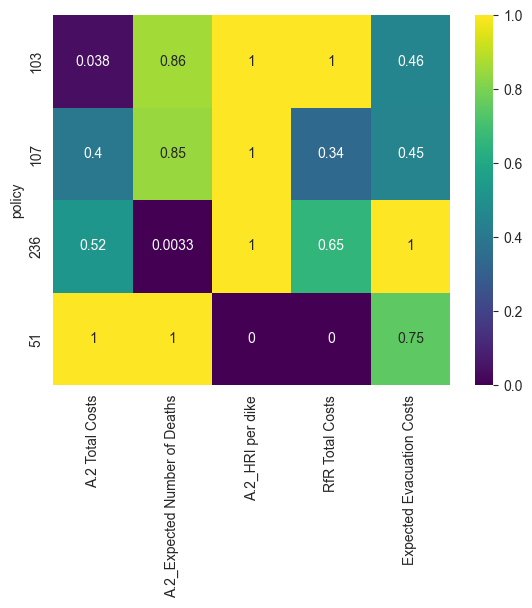

In [453]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()